In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [70]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words=words[:n1])          # 80%
Xdev, Ydev = build_dataset(words=words[n1:n2])      # 10%
Xte, Yte = build_dataset(words=words[n2:])          # 10%

torch.Size([182580, 3]) torch.int64 torch.Size([182580]) torch.int64
torch.Size([22767, 3]) torch.int64 torch.Size([22767]) torch.int64
torch.Size([22799, 3]) torch.int64 torch.Size([22799]) torch.int64


In [ ]:
n_embd = 10 # the dimenstionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the NLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),            generator=g)
W1 = torch.randn((block_size*n_embd,n_hidden),  generator=g) * (5/3)/((n_embd * block_size)**0.5) # Kaiming init for tanh
# b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2,bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # num of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    #constructing minibatches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concate the vectors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation

    #-------------------Batch norm-------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #-------------------Batch norm-------------------------------


    # Non linearality 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    #backwakrd pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.3321
  10000/ 200000: 2.4543
  20000/ 200000: 2.3642
  30000/ 200000: 2.0912
  40000/ 200000: 2.1876
  50000/ 200000: 2.4354
  60000/ 200000: 2.2514
  70000/ 200000: 2.1392
  80000/ 200000: 2.1197
  90000/ 200000: 2.0352
 100000/ 200000: 2.4256
 110000/ 200000: 2.1283
 120000/ 200000: 2.2154
 130000/ 200000: 2.2886
 140000/ 200000: 2.1867
 150000/ 200000: 2.3596
 160000/ 200000: 2.2134
 170000/ 200000: 2.0421
 180000/ 200000: 2.3635
 190000/ 200000: 1.9045


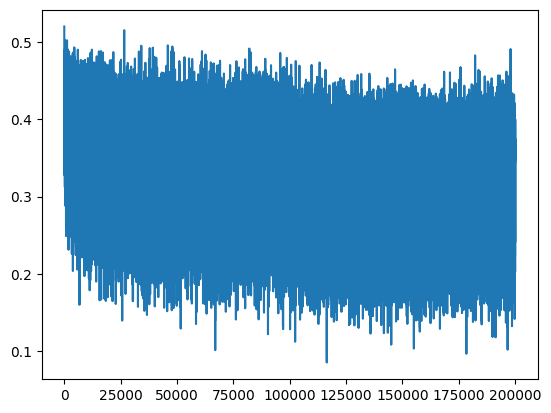

In [44]:
plt.plot(lossi)

In [66]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]

    emb = C[x] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, y) # loss function
    print(loss)

split_loss('train')
split_loss('val')

tensor(2.0657)
tensor(2.1090)


# Result

In [50]:
g = torch.Generator().manual_seed(44572)

for _ in range(20):
    out =[]
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break;

    print(''.join(itos[i] for i in out))

romara.
amontani.
ash.
wree.
liley.
kharlo.
side.
bunualin.
vangeleah.
noe.
eveer.
aion.
kris.
abmarceno.
ilianyy.
iona.
lil.
amartante.
zaliah.
dewiana.


In [15]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

# Pytorchify the Makemore

In [89]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a runneng "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [90]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #constructing minibatches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the character into vectors
    x = emb.view(emb.shape[0], -1) # concate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backwakrd pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    if i > 1000:
        break

      0/ 200000: 3.3073


layer 1 (      Tanh): mean -0.03, std 0.64, saturated: 4.84%
layer 3 (      Tanh): mean +0.01, std 0.54, saturated: 0.44%
layer 5 (      Tanh): mean -0.00, std 0.52, saturated: 0.44%
layer 7 (      Tanh): mean -0.04, std 0.52, saturated: 0.44%
layer 9 (      Tanh): mean -0.01, std 0.54, saturated: 0.16%


Text(0.5, 1.0, 'activation distribution')

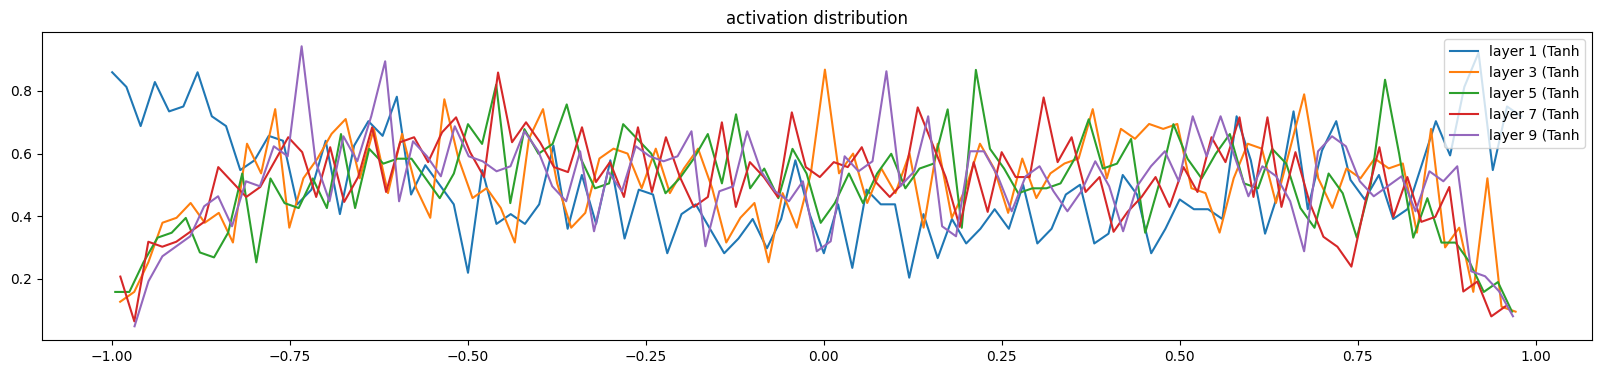

In [91]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000011, std 2.596123e-03
layer 3 (      Tanh): mean -0.000020, std 2.428628e-03
layer 5 (      Tanh): mean -0.000008, std 2.337124e-03
layer 7 (      Tanh): mean -0.000013, std 2.297772e-03
layer 9 (      Tanh): mean -0.000004, std 2.046090e-03


Text(0.5, 1.0, 'gradient distribution')

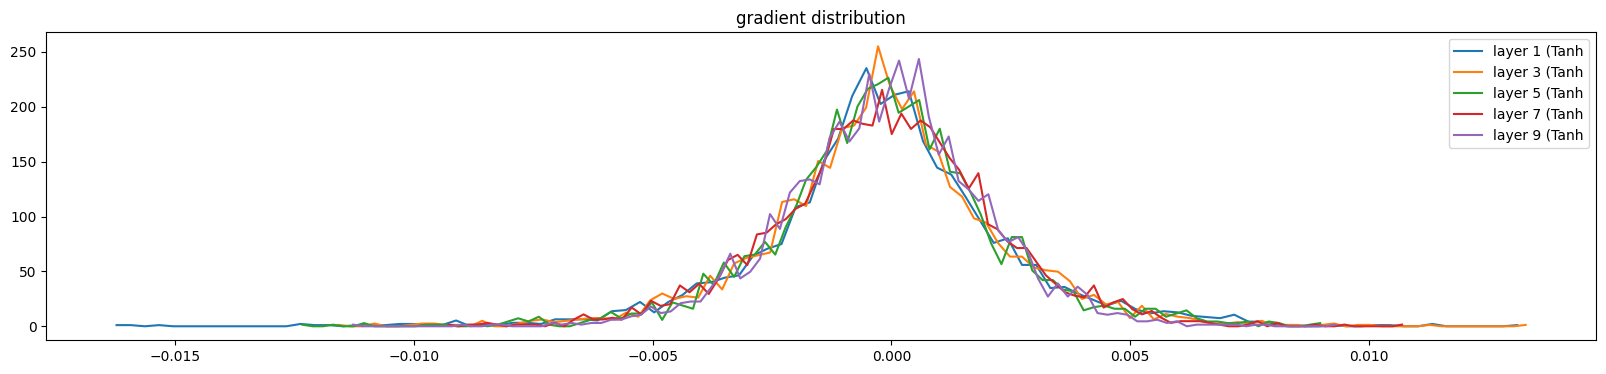

In [92]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000228 | std 9.437386e-03 | grad:data ratio 9.377490e-03
weight  (30, 100) | mean +0.000223 | std 9.220828e-03 | grad:data ratio 4.813661e-02
weight (100, 100) | mean +0.000033 | std 6.430507e-03 | grad:data ratio 6.234696e-02
weight (100, 100) | mean -0.000015 | std 5.391164e-03 | grad:data ratio 5.211291e-02
weight (100, 100) | mean -0.000032 | std 5.060104e-03 | grad:data ratio 4.918798e-02
weight (100, 100) | mean +0.000030 | std 4.245679e-03 | grad:data ratio 4.136339e-02
weight  (100, 27) | mean -0.000000 | std 1.582765e-02 | grad:data ratio 2.493392e-01


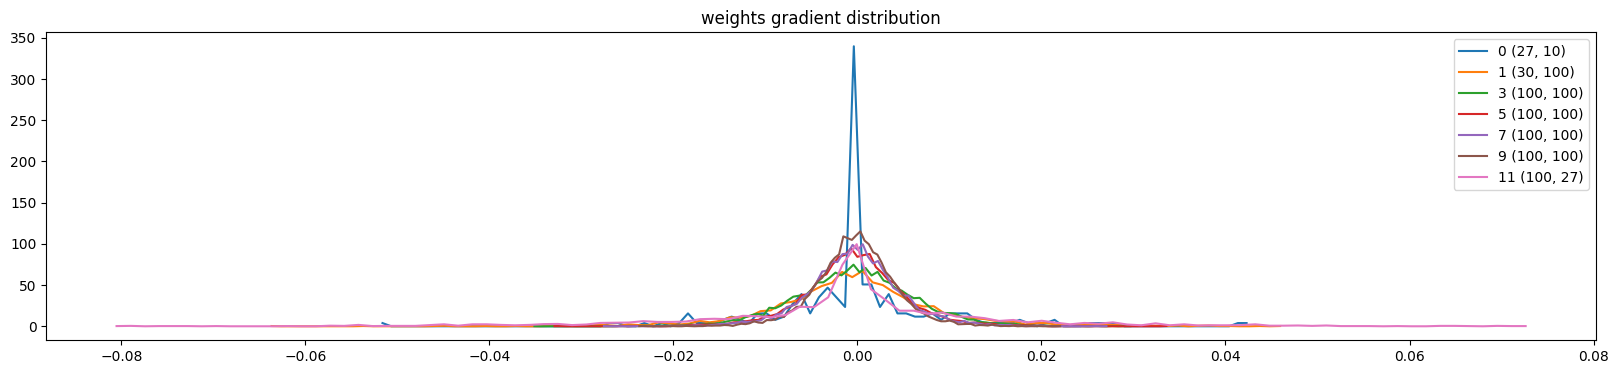

In [93]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

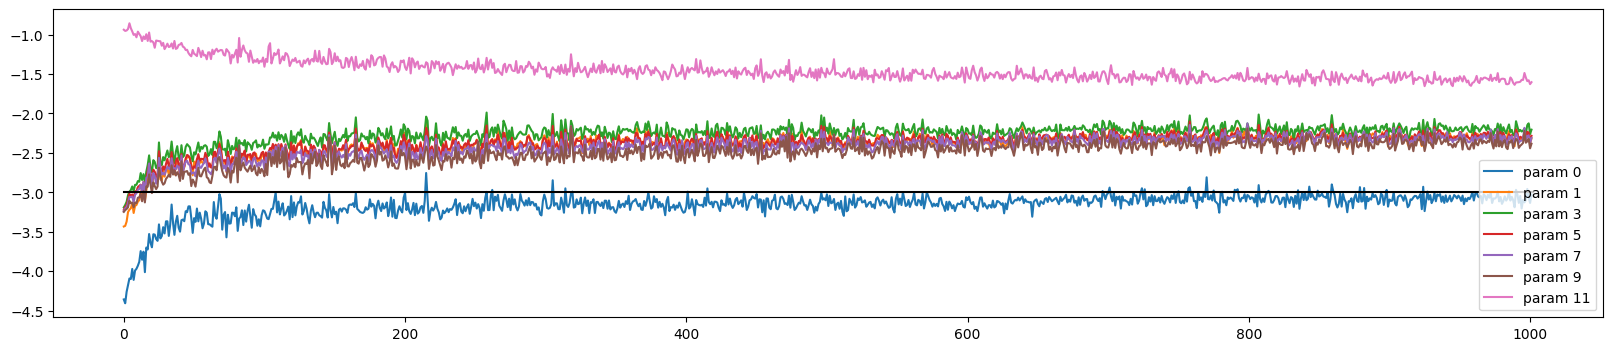

In [94]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);